In [1]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import pickle

In [2]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"
df = get_match_data(base_url.format(season))
ws = get_winstreak(df)

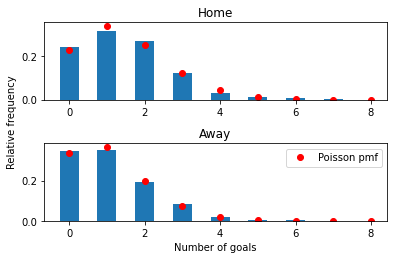

In [3]:
### Histogram of home and away goals
fig, axs = plt.subplots(2,1)
bins = [i for i in range(9)]

axs[0].hist(df["FTHG"], density=True,bins=bins, align="left", rwidth=0.5)
axs[1].hist(df["FTAG"], density=True,bins=bins, align="left", rwidth=0.5)
axs[0].set_title("Home")
axs[1].set_title("Away")

home_mean = df.mean(axis=0)["FTHG"]
away_mean = df.mean(axis=0)["FTAG"]

axs[0].plot(bins, poisson.pmf(bins, home_mean), 'ro', label="Poisson pmf")
axs[1].plot(bins, poisson.pmf(bins, away_mean), 'ro',label="Poisson pmf")
plt.legend()

### Common axes labels
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.xlabel("Number of goals")
plt.ylabel("Relative frequency")
plt.tight_layout()

# plt.savefig("figures/poisson_frequency.jpeg", dpi=300)

In [4]:
### Chi-sq goodness of fit test

### Home
home_mean = df.mean(axis=0)["FTHG"]
home_count = df["FTHG"].value_counts(sort=False) # 5 or more

home_count = [home_count[i] for i in range(4)]
home_count.append(380 - sum(home_count))
home_count = np.array(home_count)

home_expected = [poisson.pmf(i, home_mean) * 380 for i in range(4)]
home_expected.append(380 - sum(home_expected))
home_expected = np.array(home_expected)


### Away
away_mean = df.mean(axis=0)["FTAG"]
away_count = df["FTAG"].value_counts(sort=False) # 4 or more

away_count = [away_count[i] for i in range(4)]
away_count.append(380 - sum(away_count))
away_count = np.array(away_count)

away_expected = [poisson.pmf(i, away_mean) * 380 for i in range(4)]
away_expected.append(380 - sum(away_expected))
away_expected = np.array(away_expected)

### Test results:
print(chisquare(home_count,home_expected, ddof=1))
print(chisquare(away_count,away_expected, ddof=1))

Power_divergenceResult(statistic=1.8572927713287892, pvalue=0.6025474430859525)
Power_divergenceResult(statistic=1.1850001915376027, pvalue=0.7566040876792556)


In [5]:
### Gradient descent / NO MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
params = np.ones((4,20))

num_itrs = 100000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])


100%|██████████| 100000/100000 [04:54<00:00, 339.43it/s]


In [6]:
### Gradient descent / MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
team_params = np.ones((4,20))
streak_param = 1

num_itrs = 100000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]
        week = row["MatchWeek"]
        home_streak = ws.loc[week,row["HomeTeam"]]
        away_streak = ws.loc[week,row["AwayTeam"]]

        # update home team params
        team_params[0,home_index] += lr * (home_goal / team_params[0,home_index] - team_params[3,away_index] * (streak_param ** home_streak))
        team_params[1,home_index] += lr * (away_goal / team_params[1,home_index] - team_params[2,away_index] * (streak_param ** away_streak))
        if home_streak != 0:
            streak_param += lr * (home_goal * home_streak / streak_param - home_streak * team_params[0,home_index] * team_params[3,away_index] * (streak_param ** (home_streak - 1)))

        # update away team params
        team_params[2,away_index] += lr * (away_goal / team_params[2,away_index] - team_params[1,home_index] * (streak_param ** away_streak))
        team_params[3,away_index] += lr * (home_goal / team_params[3,away_index] - team_params[0,home_index] * (streak_param ** home_streak))
        if away_streak != 0:
            streak_param += lr * (away_goal * away_streak / streak_param - away_streak * team_params[2,away_index] * team_params[1,home_index] * (streak_param ** (away_streak - 1)))


100%|██████████| 100000/100000 [05:55<00:00, 281.68it/s]


In [11]:
# ### Save trained params DON'T UNCOMMENT
# ### Params trained with itrs=100,000, lr=0.0001
# saved_params = [params, team_params, streak_param]
# with open('saved_data/params.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_params, f, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('saved_data/params.pickle', 'rb') as f:
    saved_params = pickle.load(f)

params = saved_params[0]
team_params = saved_params[1]
streak_param = saved_params[2]

In [6]:
table_params = pd.DataFrame(data=params.T,columns=["O_H", "D_H", "O_A", "D_A"])
table_params["Team"] = list(teams_ind.keys())
table_params

,O_H,D_H,O_A,D_A,Team
0,1.738582,0.742338,1.470573,0.975134,Arsenal
1,0.786218,1.256320,0.657507,1.379943,Aston Villa
2,0.607005,1.046457,0.704753,1.367899,Burnley
3,1.531932,0.479857,1.778803,0.999144,Chelsea
4,0.899557,1.397173,1.310036,1.037448,Crystal Palace
5,1.171454,1.074689,1.031256,1.262251,Everton
6,0.824671,1.196245,0.699692,1.171258,Hull
7,1.218192,1.118692,0.905273,1.448746,Leicester
8,1.301271,1.029623,1.088170,1.237187,Liverpool
9,1.867223,0.755228,1.910573,1.080545,Man City


In [8]:
### Simulate 10,000 leagues // NO MOMENTUM

num_itrs = 10000

top4_count = np.zeros(20)
win_count = np.zeros(20)
bottom4_count = np.zeros(20)

sim = df.copy(deep=True)
sim["FTHG"] = np.nan
sim["FTAG"] = np.nan
sim["FTR"] = np.nan

for i in tqdm(range(num_itrs)):
    standings = simulate_with_standings(sim, params, teams_ind)
    for team in get_top4(standings):
        top4_count[teams_ind[team]] += 1
    for team in get_bottom4(standings):
        bottom4_count[teams_ind[team]] += 1
    win_count[teams_ind[get_winner(standings)[1]]] += 1

100%|██████████| 10000/10000 [07:09<00:00, 23.28it/s]


In [9]:
# ### Save simulation results DON'T UNCOMMENT
# saved_sims = [win_count, top4_count, bottom4_count]
# with open('saved_data/counts.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_sims, f, pickle.HIGHEST_PROTOCOL)

In [26]:
with open('saved_data/counts.pickle', 'rb') as f:
    saved_sims = pickle.load(f)

win_count = saved_sims[0]
top4_count = saved_sims[1]
bottom4_count = saved_sims[2]

winners = pd.DataFrame(data=np.array([list(teams_ind.keys()), win_count]).T, columns = ["Team", "Count"])
winners = winners.astype({"Count": float})
winners = winners.loc[winners["Count"] >= 1]
winners = winners.sort_values(by="Count", ascending=False)

top4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), top4_count]).T, columns = ["Team", "Count"])
top4 = top4.astype({"Count": float})
top4 = top4.loc[top4["Count"] >= 1]
top4 = top4.sort_values(by="Count", ascending=False)

bottom4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), bottom4_count]).T, columns = ["Team", "Count"])
bottom4 = bottom4.astype({"Count": float})
bottom4 = bottom4.loc[bottom4["Count"] >= 1]
bottom4 = bottom4.sort_values(by="Count", ascending=False)

<ipython-input-20-5a5bec8d0565>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')
<ipython-input-20-5a5bec8d0565>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')
<ipython-input-20-5a5bec8d0565>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(labels=bottom4["Team"],rotation='vertical')


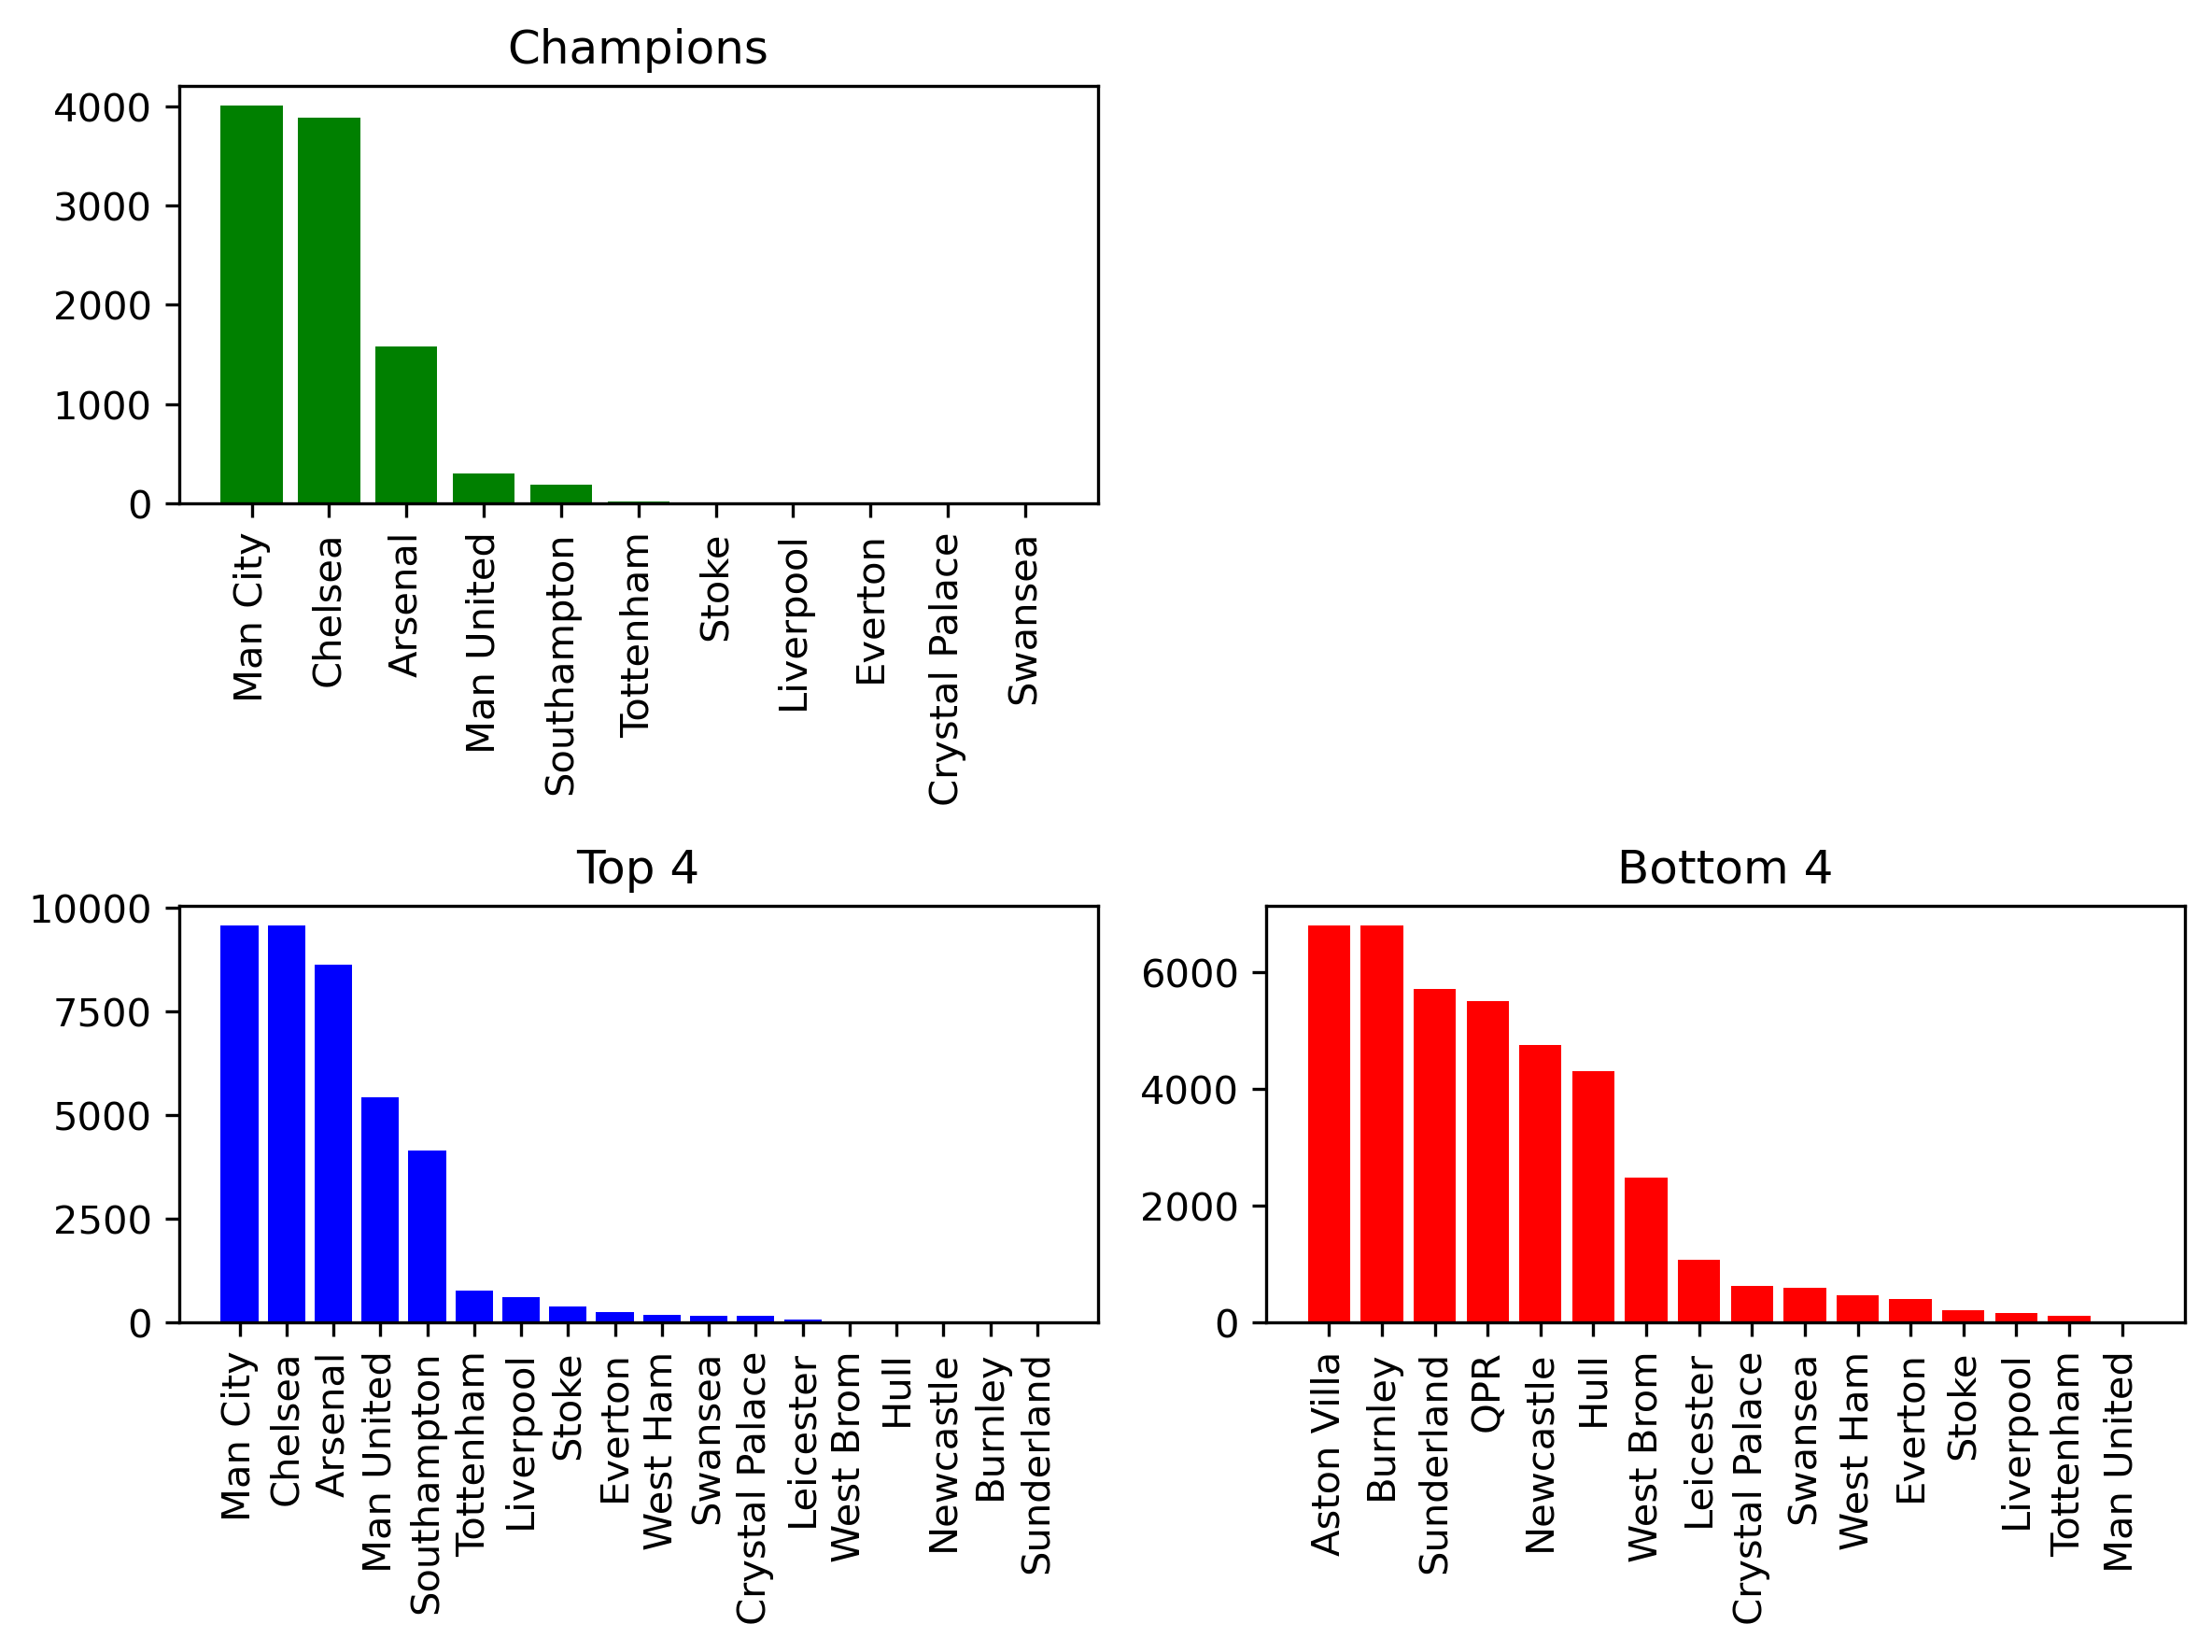

In [20]:
fig, axes = plt.subplots(2,2, figsize=(8,6), dpi=300)
axes[0,0].bar(winners["Team"], winners["Count"], color="g")
axes[0,0].set_title("Champions")
axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')

fig.delaxes(axes[0,1])

axes[1,0].bar(top4["Team"], top4["Count"], color="b")
axes[1,0].set_title("Top 4")
axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')

axes[1,1].bar(bottom4["Team"], bottom4["Count"], color="r")
axes[1,1].set_title("Bottom 4")
axes[1,1].set_xticklabels(labels=bottom4["Team"],rotation='vertical')

plt.tight_layout()

In [15]:
### Simulate 10000 runs // MOMENTUM

num_itrs = 10000

top4_count = np.zeros(20)
win_count = np.zeros(20)
bottom4_count = np.zeros(20)

sim = df.copy(deep=True)
sim["FTHG"] = np.nan
sim["FTAG"] = np.nan
sim["FTR"] = np.nan

for i in tqdm(range(num_itrs)):
    standings = sim_with_standings_momentum(sim, team_params, streak_param, teams_ind, streaks=np.zeros((38,20), dtype=int))
    for team in get_top4(standings):
        top4_count[teams_ind[team]] += 1
    for team in get_bottom4(standings):
        bottom4_count[teams_ind[team]] += 1
    win_count[teams_ind[get_winner(standings)[1]]] += 1

100%|██████████| 10000/10000 [09:21<00:00, 17.82it/s]


In [17]:
# ### Save simulation results DON'T UNCOMMENT
# saved_sims = [win_count, top4_count, bottom4_count]
# with open('saved_data/counts_momentum.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_sims, f, pickle.HIGHEST_PROTOCOL)

In [27]:
with open('saved_data/counts_momentum.pickle', 'rb') as f:
    saved_sims = pickle.load(f)

win_count_momentum = saved_sims[0]
top4_count_momentum = saved_sims[1]
bottom4_count_momentum = saved_sims[2]

winners_momentum = pd.DataFrame(data=np.array([list(teams_ind.keys()), win_count_momentum]).T, columns = ["Team", "Count"])
winners_momentum = winners_momentum.astype({"Count": float})
winners_momentum = winners_momentum.loc[winners_momentum["Count"] >= 1]
winners_momentum = winners_momentum.sort_values(by="Count", ascending=False)

top4_momentum = pd.DataFrame(data=np.array([list(teams_ind.keys()), top4_count_momentum]).T, columns = ["Team", "Count"])
top4_momentum = top4_momentum.astype({"Count": float})
top4_momentum = top4_momentum.loc[top4_momentum["Count"] >= 1]
top4_momentum = top4_momentum.sort_values(by="Count", ascending=False)

bottom4_momentum = pd.DataFrame(data=np.array([list(teams_ind.keys()), bottom4_count_momentum]).T, columns = ["Team", "Count"])
bottom4_momentum = bottom4_momentum.astype({"Count": float})
bottom4_momentum = bottom4_momentum.loc[bottom4_momentum["Count"] >= 1]
bottom4_momentum = bottom4_momentum.sort_values(by="Count", ascending=False)


<ipython-input-39-d7e7d9b117c4>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')
<ipython-input-39-d7e7d9b117c4>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(labels=winners_momentum["Team"],rotation='vertical')
<ipython-input-39-d7e7d9b117c4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')
<ipython-input-39-d7e7d9b117c4>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(labels=top4_momentum["Team"],rotation='vertical')
<ipython-input-39-d7e7d9b117c4>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,0].set_xticklabels(labels=bottom4["Team"],rotation='vertical')
<ipython-input-39-d7e7d9b117c4>:22: UserWarning: FixedFormatter should only

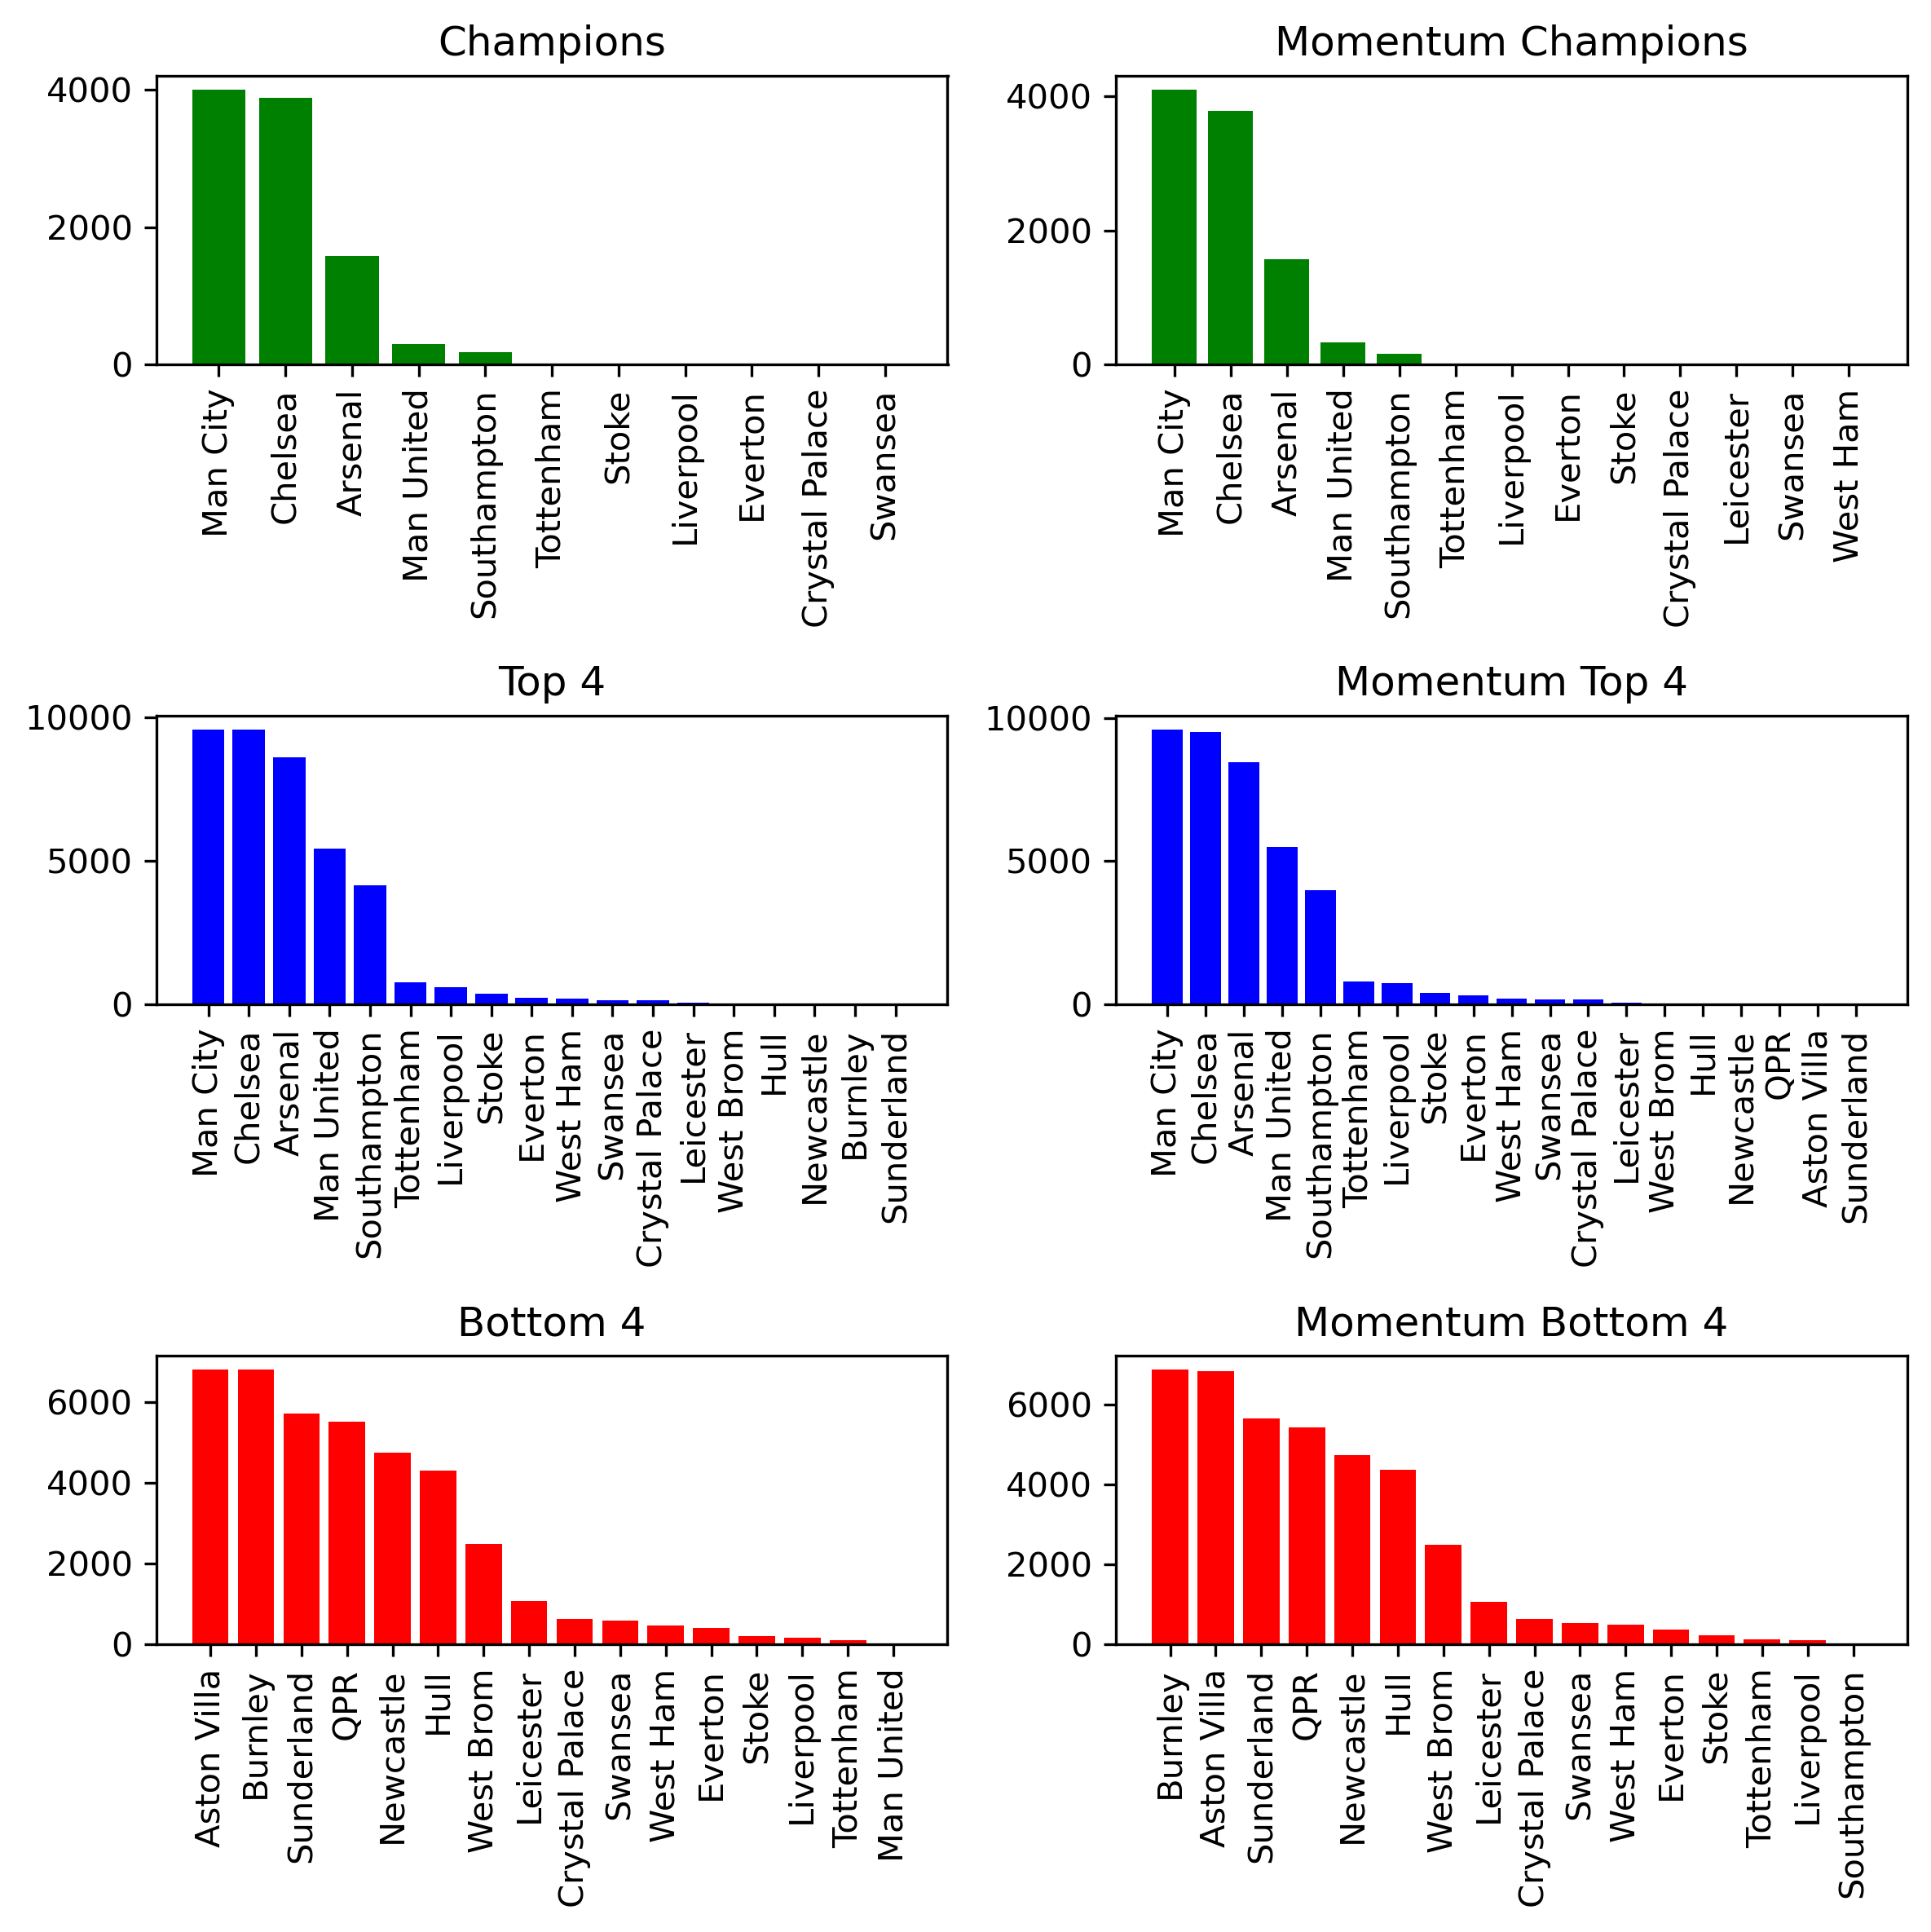

In [39]:
fig, axes = plt.subplots(3,2, figsize=(8,8),dpi=300)

axes[0,0].bar(winners["Team"], winners["Count"], color="g")
axes[0,0].set_title("Champions")
axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')
axes[0,1].bar(winners_momentum["Team"], winners_momentum["Count"], color="g")
axes[0,1].set_title("Momentum Champions")
axes[0,1].set_xticklabels(labels=winners_momentum["Team"],rotation='vertical')

axes[1,0].bar(top4["Team"], top4["Count"], color="b")
axes[1,0].set_title("Top 4")
axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')
axes[1,1].bar(top4_momentum["Team"], top4_momentum["Count"], color="b")
axes[1,1].set_title("Momentum Top 4")
axes[1,1].set_xticklabels(labels=top4_momentum["Team"],rotation='vertical')

axes[2,0].bar(bottom4["Team"], bottom4["Count"], color="r")
axes[2,0].set_title("Bottom 4")
axes[2,0].set_xticklabels(labels=bottom4["Team"],rotation='vertical')
axes[2,1].bar(bottom4_momentum["Team"], bottom4_momentum["Count"], color="r")
axes[2,1].set_title("Momentum Bottom 4")
axes[2,1].set_xticklabels(labels=bottom4_momentum["Team"],rotation='vertical')

plt.tight_layout()
plt.savefig('figures/simulation.jpeg', dpi=300)

<ipython-input-22-a317745d40ab>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')
<ipython-input-22-a317745d40ab>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')
<ipython-input-22-a317745d40ab>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(labels=bottom4["Team"],rotation='vertical')


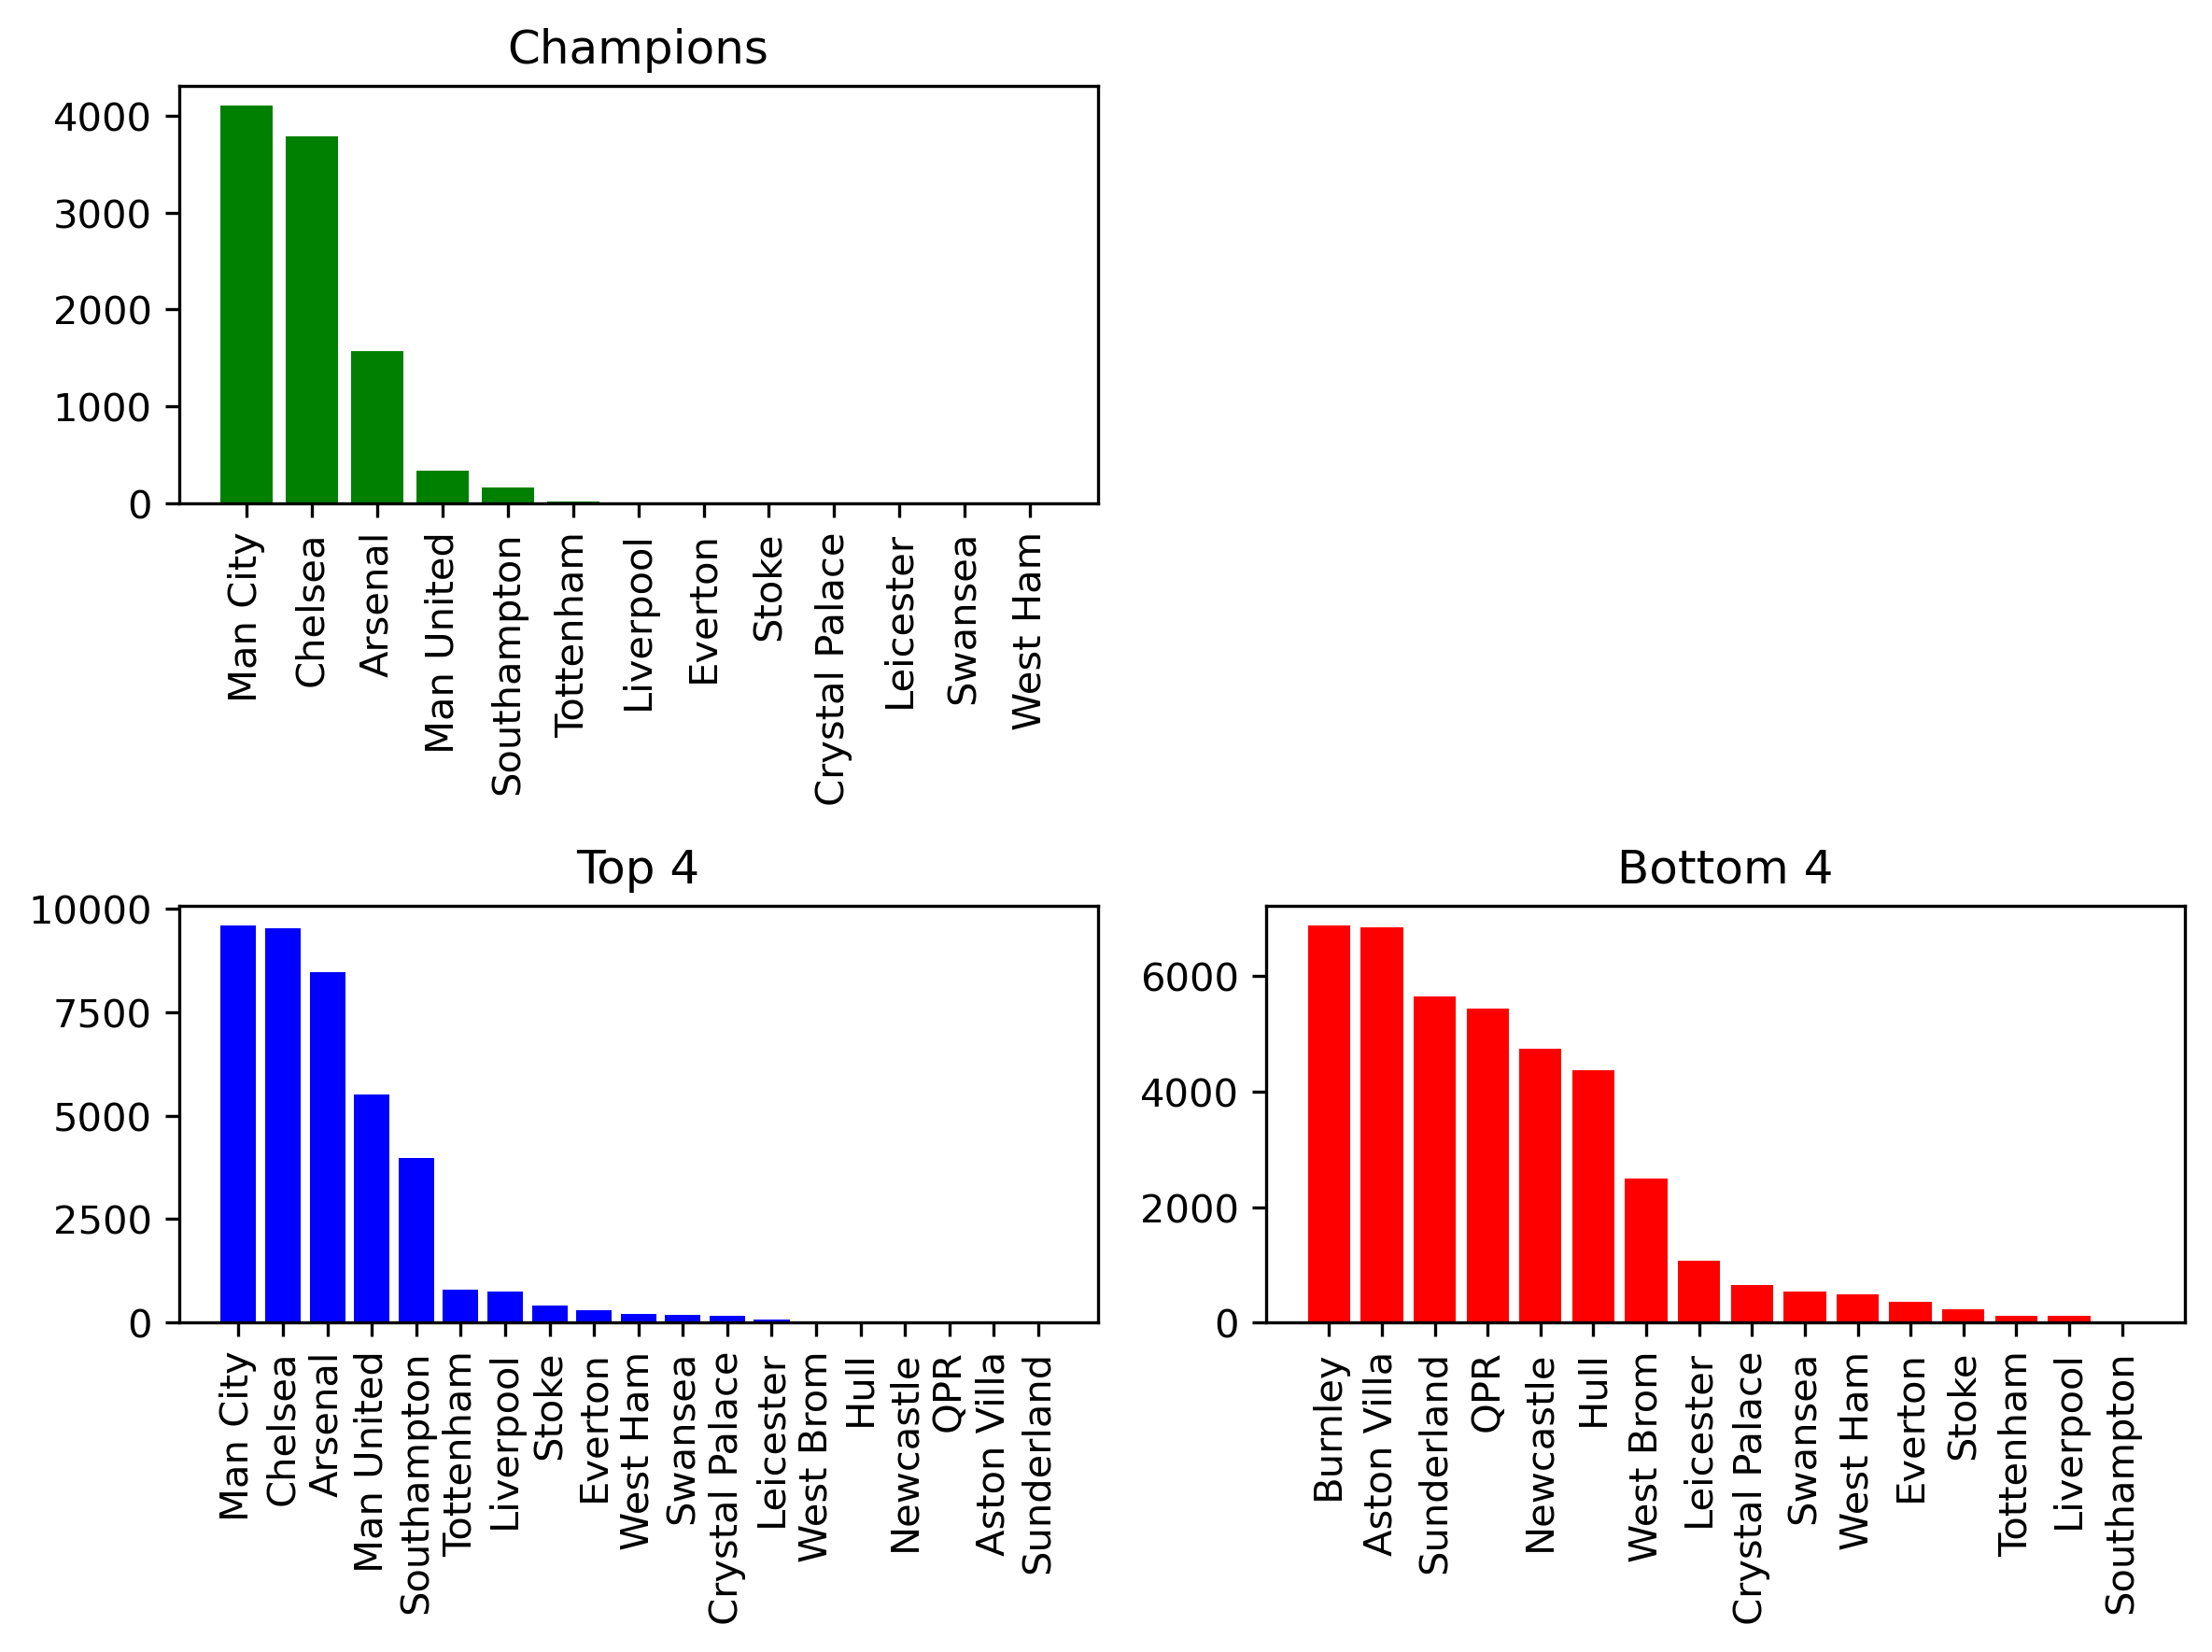

In [22]:
fig, axes = plt.subplots(2,2, figsize=(8,6), dpi=300)
axes[0,0].bar(winners["Team"], winners["Count"], color="g")
axes[0,0].set_title("Champions")
axes[0,0].set_xticklabels(labels=winners["Team"],rotation='vertical')

fig.delaxes(axes[0,1])

axes[1,0].bar(top4["Team"], top4["Count"], color="b")
axes[1,0].set_title("Top 4")
axes[1,0].set_xticklabels(labels=top4["Team"],rotation='vertical')

axes[1,1].bar(bottom4["Team"], bottom4["Count"], color="r")
axes[1,1].set_title("Bottom 4")
axes[1,1].set_xticklabels(labels=bottom4["Team"],rotation='vertical')

plt.tight_layout()
# plt.savefig('figures/simulation_momentum.jpeg', dpi=300)